# A reference source for house buyers in the Capital Region of Finland


## 1. Description of the problem and discussion of the background

Currently, I am living with my family in Finland. Our family is planning to buy our own house to settle down. We are a middle-class family with a little child and buying a house is a huge investment for us. That's why we would like to have more information of a certain living area before deciding. Our criteria contain average house price and the availabilities of social services of the area especially services for little children. Besides, during over a year of pandemic, mostly we work remotely from home, this means we can choose a house in countryside or quiet area but near to public transportation. Therefore, although we prefer the capital area to live, we also open to see options from quiet area in the capital area of Finland

The Finnish Capital Region consists of four municipalities with city title, Helsinki, Vantaa, Espoo and Kauniainen, whose total population is about 1.2 million (2020). The vast majority of the inhabitants live in the urban areas of the cities, but within the boundaries of these cities there are also suburban and rural areas.

## 2. Data description
Based on the definition of given problem, factors which will effect the acquisition of data are:
* house price. 
* Social services for basic wellbeing for people, especially for children
* Public transportation close by especially train/metro station

Following data sources will be needed to extract/generate the required information:
* The list of areas in the capital region of Finland. This information can be found in National Statistical Service of Finland
* Geographic information of each areas such as latitude and longitude can be calculated by using Pgeocode library
* House price or price per square meter in each area, this information also can be found and obtained from National Statistical Service of Finland
* Social services (grocery store, education services, hospital, etc) and pubic transportation (train/metro station, etc) will be obtained by using Foursquare API

This section show the work of data acquisition and data wrangling

### 2.1 Collect postal code, latitude and longitude of each area in the capital region of Finland

In [1]:
# import needed packages
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import pgeocode
from geopy.geocoders import Nominatim

import sys
# install openpyxl (A Python library to read/write Excel 2010 xlsx/xlsm files) if needed

print('Libraries imported.') 

Libraries imported.


In [2]:
filepath = sys.path[0] + '/finland_postalcode.xlsx'
data = pd.read_excel(filepath,sheet_name='Postal code - municipality 2021', skiprows=range(2), dtype = {'Postal code area':str})

# I need 3 columns in the dataframe
df = data[['Postal code area','Name of the postal code area','Name of the municipality']]

#rename columns for easy access
df = df.rename(columns={'Postal code area':'postalcode','Name of the municipality':'municipality','Name of the postal code area':'area'})

Because I focus on finding house in the captial region of Finland. The Finnish Capital Region consists of four municipalities with city title, Helsinki, Vantaa, Espoo and Kauniainen. So I will extract data from 4 municipalities only

In [3]:
municipalities = ['Helsinki','Vantaa','Espoo', 'Kauniainen']
# condition: df['municipality'].isin(municipalities)
df_capital = df[df['municipality'].isin(municipalities)]

In [4]:
df_capital.shape

(168, 3)

In [5]:
df_capital.groupby('municipality').count()

,postalcode,area
municipality,,
Espoo,46,46
Helsinki,84,84
Kauniainen,1,1
Vantaa,37,37


I have postal code for all areas in the capital region of Finland. I need the data of latitude and longitude of each area for later use in FourSquare API to obtain more detaitl of venues. To get this information, I use Pgeocode library to get latitude an longitude based on the postal code. More information about Pgeocode can be found here: https://pypi.org/project/pgeocode/ 

In [6]:
# get latitude and longitude of each area
postalcodes = df_capital['postalcode']

# an empty list, it will contain postal code, latitude and longitude of each area
code_list = []
# loop throung all postal codes of Finland
for postalcode in postalcodes:
    # initial dict named cell
    cell = {}
    
    # getting data 
    nomi = pgeocode.Nominatim('fi')
    location = nomi.query_postal_code(postalcode)
    latitude = location.latitude
    longitude = location.longitude
    
    # put data into dict
    cell['postalcode'] = postalcode
    cell['latitude'] = latitude
    cell['longitude'] = longitude

    # add cell to list
    code_list.append(cell)

In [7]:
df_code = pd.DataFrame(code_list)
#df_code.head(10)

Merge or join 2 dataframes df_capital and df_code to get all data together, like the result shows below

In [8]:
df_capital_geo = pd.merge(df_capital,df_code, on='postalcode')
df_capital_geo.head()

,postalcode,area,municipality,latitude,longitude
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316
1,00120,Punavuori,Helsinki,60.1632,24.9391
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525
4,00150,Eira - Hernesaari,Helsinki,60.1570,24.9369


In [9]:
df_capital_geo.shape

(168, 5)

### 2.2 Get house price for each area

In [10]:
# finland_avg_house_price.xlsx contains price per square meter in each area of Finland.
filepath = sys.path[0] + '/finland_avg_house_price.xlsx'
df_price = pd.read_excel(filepath,sheet_name='014_112q_2020', skiprows=range(3))
df_price.head()

,Unnamed: 0,Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),7575
1,00120 Punavuori (Helsinki ),8160
2,00130 Kaartinkaupunki (Helsinki ),7825
3,00140 Kaivopuisto - Ullanlinna (Helsinki ),8713
4,00150 Eira - Hernesaari (Helsinki ),8367


I do some data cleaning in this step, such as: extract postal code, delete all row which have no price (missing values because of no record), rename for later easy access, drop unneccessary column

In [11]:
# extract postal code and save in new columns
df_price['postalcode']= df_price['Unnamed: 0'].str[0:5]
# delete postalcode in the name
df_price['Unnamed: 0'] = df_price['Unnamed: 0'].str[5:]
# delete all rows have no price (missing values, not record)
df_price = df_price[df_price['Price per square meter (EUR/m2)'] != '..']
#rename the column for easier use later
df_price= df_price.rename(columns={'Price per square meter (EUR/m2)':'price_per_m2'})
#drop 'Unnamed: 0', we don't need it
df_price = df_price.drop('Unnamed: 0', axis=1)

In [12]:
#merge 2 dataframes
df_price_geo = pd.merge(df_capital_geo,df_price, on='postalcode')
df_price_geo.shape

(148, 6)

In [13]:
df_price_geo.head()

,postalcode,area,municipality,latitude,longitude,price_per_m2
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316,7575
1,00120,Punavuori,Helsinki,60.1632,24.9391,8160
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487,7825
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525,8713
4,00150,Eira - Hernesaari,Helsinki,60.1570,24.9369,8367


In [14]:
df_price_geo.dtypes

postalcode       object
area             object
municipality     object
latitude        float64
longitude       float64
price_per_m2     object
dtype: object

In [15]:
# change data types of price_per_m2
df_price_geo['price_per_m2'] = df_price_geo['price_per_m2'].astype(int)

In [16]:
#df_price_geo.to_excel('fin_price_geo.xlsx')

### 2.3 Get data of social services in each areas using FourSquare API

In [17]:
# Let's take a quick look of areas in the capital region in the map

# Let's get the geographical coordinates of Helsinki area 
address = 'Helsinki, Finland'

geolocator = Nominatim(user_agent="finland_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# making map
map_captial = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, area, municipality in zip(df_price_geo['latitude'], df_price_geo['longitude'],df_price_geo['area'], df_price_geo['municipality'],):
    label = '{},{}'.format(area,municipality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_captial)  
    
map_captial

In [18]:
#Define Foursquare Credentials and Version

# To keep the privacy of my client_id and client_secret, I edited them after running the cell 
#CLIENT_ID = '******************************************' # Foursquare ID
#CLIENT_SECRET = '******************************************' # Foursquare Secret

VERSION = '20210413' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

I decided to get the top 100 venues that are in each area within a radius of 1 km (1000 meters), it is walkable distance. So if an area have adequate services in walkable distance, it is suitable to consider to buy a house.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
# Get all venues of each area in dataset
all_venues = getNearbyVenues(names=df_price_geo['area'],
                                   latitudes=df_price_geo['latitude'],
                                   longitudes=df_price_geo['longitude'])

Helsinki Keskusta - Etu-Töölö
Punavuori
Kaartinkaupunki
Kaivopuisto - Ullanlinna
Eira - Hernesaari
Katajanokka
Kruununhaka
Kamppi - Ruoholahti
Lauttasaari
Vattuniemi
Jätkäsaari
Länsi-Pasila
Taka-Töölö
Keski-Töölö
Pohjois-Meilahti
Ruskeasuo
Pikku Huopalahti
Kivihaka
Etelä-Haaga
Munkkiniemi
Kuusisaari-Lehtisaari
Munkkivuori-Niemenmäki
Pajamäki
Reimarla
Pitäjänmäen teollisuusalue
Konala
Pohjois-Haaga
Malminkartano
Kannelmäki
Maununneva
Lassila
Sörnäinen
Etu-Vallila - Alppila
Itä-Pasila
Kallio
Kalasatama
Vallila
Toukola-Vanhakaupunki
Kulosaari
Verkkosaari
Kaitalahti
Koskela-Helsinki
Käpylä
Metsälä-Etelä-Oulunkylä
Maunula-Suursuo
Oulunkylä-Patola
Veräjämäki
Länsi-Pakila
Paloheinä
Itä-Pakila
Tuomarinkylä-Torpparinmäki
Malmi
Pihlajamäki
Pukinmäki-Savela
Tapanila
Siltamäki
Puistola
Suurmetsä
Jakomäki - Alppikylä
Tapaninvainio
Viikki
Länsi-Herttoniemi
Herttoniemi
Roihuvuori
Tammisalo
Laajasalo
Jollas
Etelä-Laajasalo
Puotinharju
Puotila
Myllypuro
Itäkeskus-Marjaniemi
Kontula - Vesala
Vartioharju

Total 4.842 venues in 148 areas are returned from Four Square API service.

In [22]:
all_venues.head()

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Taidehalli,60.172127,24.931014,Art Gallery
1,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Ateljé Finne,60.171198,24.928515,Scandinavian Restaurant
2,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Baana,60.169973,24.928837,Road
3,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Twisted Street Kitchen,60.170641,24.928203,Asian Restaurant
4,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Arkadia Oy International Bookshop,60.173369,24.929330,Bookstore


In [23]:
# display and count Venue category
all_venues['Venue Category'].value_counts()

Bus Stop                           524
Pizza Place                        190
Park                               172
Café                               171
Grocery Store                      151
Supermarket                        122
Coffee Shop                        109
Gym / Fitness Center               100
Scandinavian Restaurant             95
Playground                          87
Restaurant                          82
Soccer Field                        80
Bar                                 79
Gym                                 62
Recreation Center                   59
Bakery                              58
Hotel                               55
Cafeteria                           50
Chinese Restaurant                  47
Sushi Restaurant                    45
Beach                               43
Liquor Store                        42
Plaza                               41
Furniture / Home Store              40
Fast Food Restaurant                39
Italian Restaurant       

In [110]:
#all_venues.to_excel('all_venues_capital.xlsx')

After checking all Venue categories, I sort out some categories which I need
* Grocery Store, Supermarket
* Service for entertainment (especially for kids): Playground, Recreation Center, Library, Pool
* Public transportation: Train Station, Metro Station, Bus Stop 

In [24]:
# filtering all rows in those needed categories
services = ['Bus Stop','Train Station','Tram Station','Metro Station','Grocery Store','Supermarket','Market','Convenience Store','Shopping Mall','Kids Store','Baby Store','Playground','Recreation Center','Pool','Gym Pool','Zoo','Indoor Play Area']
all_venues = all_venues[all_venues['Venue Category'].isin(services)]

In [25]:
all_venues.shape

(1092, 7)

In [26]:
# 'Grocery Store','Supermarket','Market','Convenience Store','Shopping Mall' are in same type, I change all of them into Market
all_venues.replace('Supermarket','Market',inplace=True)
all_venues.replace('Grocery Store','Market',inplace=True)
all_venues.replace('Convenience Store','Market',inplace=True)
all_venues.replace('Shopping Mall','Market',inplace=True)
# 'Kids Store' and'Baby Store' are the same
all_venues.replace('Kids Store','Baby Store',inplace=True)
all_venues.replace('Gym Pool','Pool',inplace=True)

In [27]:
venue_categories = all_venues['Venue Category'].value_counts()
venue_categories

Bus Stop             524
Market               336
Playground            87
Recreation Center     59
Pool                  32
Train Station         21
Tram Station          13
Baby Store             6
Zoo                    5
Metro Station          5
Indoor Play Area       4
Name: Venue Category, dtype: int64

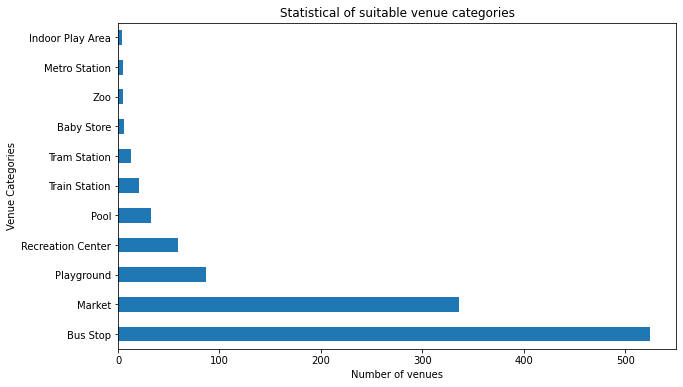

In [28]:
venue_categories.plot(kind='barh', figsize=(10,6))
plt.xlabel('Number of venues')
plt.ylabel('Venue Categories')
plt.title('Statistical of suitable venue categories')
plt.show()

In [29]:
all_venues.reset_index(drop=True,inplace=True)
all_venues.head()

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Yrjönkadun uimahalli,60.168234,24.939272,Pool
1,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Food Market Herkku,60.168128,24.942618,Market
2,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Leikkipaikka Lastenlehto,60.166508,24.929006,Playground
3,Helsinki Keskusta - Etu-Töölö,60.1714,24.9316,Leikkipaikka Töölönlahdenpuisto,60.176890,24.935318,Playground
4,Punavuori,60.1632,24.9391,Yrjönkadun uimahalli,60.168234,24.939272,Pool


In [30]:
#Let's take a quick look of how many venue are returnt in each area
summary = all_venues[['Area','Venue']].groupby('Area').count().reset_index()
summary['Number of Venues'] = summary['Venue']
summary.drop('Venue', inplace=True, axis=1)
summary.sort_values('Number of Venues',ascending=False).head()

,Area,Number of Venues
75,Maunula-Suursuo,18
54,Käpylä,17
14,Herttoniemi,17
12,Haukilahti,17
91,Otsolahti,16


The dataset of all_venues contains 1093 records, I will use this dataset to cluster and segment all areas in the capital region of Finland.

## 3. Methodology
* I will use Kmeans algorithmn for the clustering and segmentation of target areas into different clusters. The clustering factors are venue categories (public transportation, services for children).
* I will use Elbow method to find a optimal K for Kmeans algorithmn
* The results of clustering and segment will be labeled friendly and later they are displayed on popup text of each area on Folium map
* In term of housing sale price, I will divide range of price into 5 categories (using function linspace of numpy library): low price, medium price, high price, expensive price and very expensive price. Those labels of house sale price are also displayed together with cluster's lalels on the folium map. 

### 3.1 Analyzing all areas of the capital region

In [31]:
# one hot encoding
venue_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
venue_onehot['Area'] = all_venues['Area'] 

# move area column to the first column
fixed_columns = [venue_onehot.columns[-1]] + list(venue_onehot.columns[:-1])
venue_onehot = venue_onehot[fixed_columns]

venue_onehot.head()

,Area,Baby Store,Bus Stop,Indoor Play Area,Market,Metro Station,Playground,Pool,Recreation Center,Train Station,Tram Station,Zoo
0,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,0,1,0,0,0,0
1,Helsinki Keskusta - Etu-Töölö,0,0,0,1,0,0,0,0,0,0,0
2,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,1,0,0,0,0,0
3,Helsinki Keskusta - Etu-Töölö,0,0,0,0,0,1,0,0,0,0,0
4,Punavuori,0,0,0,0,0,0,1,0,0,0,0


In [32]:
venue_onehot.shape

(1092, 12)

In [33]:
venue_grouped = venue_onehot.groupby('Area').mean().reset_index()
venue_grouped.head()

,Area,Baby Store,Bus Stop,Indoor Play Area,Market,Metro Station,Playground,Pool,Recreation Center,Train Station,Tram Station,Zoo
0,Aurinkolahti,0.0,0.250000,0.0,0.250000,0.0,0.250000,0.000000,0.250000,0.0,0.000000,0.0
1,Espoon Keskus,0.0,0.444444,0.0,0.333333,0.0,0.111111,0.111111,0.000000,0.0,0.000000,0.0
2,Espoonlahti,0.0,0.428571,0.0,0.285714,0.0,0.214286,0.071429,0.000000,0.0,0.000000,0.0
3,Etelä-Haaga,0.0,0.727273,0.0,0.090909,0.0,0.000000,0.000000,0.090909,0.0,0.090909,0.0
4,Etelä-Laajasalo,0.0,0.600000,0.0,0.400000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [34]:
venue_grouped_clustering = venue_grouped.drop('Area',axis=1)

Elbow Method for finding optimal value of k in KMeans

In [35]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(init = "k-means++", n_clusters=k, n_init = 12).fit(venue_grouped_clustering)
    kmeanModel.fit(venue_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(venue_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / venue_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)

In [36]:
inertias

[24.898000171186933,
 14.570438283774735,
 11.511316541510075,
 9.384557480311912,
 8.236256835528028,
 7.323321033959488,
 6.50371213744921,
 5.825130482402841,
 5.296006021833461]

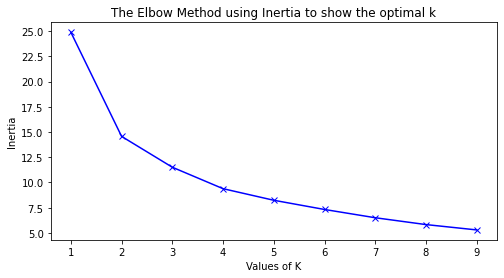

In [37]:
# plotting
plt.figure(figsize=(8,4))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia to show the optimal k')
plt.show()

In [38]:
# The optimal K is 4. So I will run Kmeans with k= 4
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(venue_grouped_clustering)
labels = k_means.labels_
labels

array([1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 1, 2, 0, 1, 1, 1, 2, 3, 2, 3, 3,
       2, 2, 0, 2, 3, 3, 1, 0, 2, 0, 3, 0, 0, 1, 1, 3, 1, 1, 0, 1, 3, 2,
       0, 1, 1, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 1, 2, 1, 3, 2, 3, 1, 1, 2,
       1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 0,
       1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 3, 3, 0, 0, 1, 3, 2, 2,
       3, 2, 3, 1, 0, 1, 1, 2, 1, 3, 1, 2, 1, 1, 2, 2, 1, 3, 1, 0, 2, 2,
       3, 2, 0, 2, 1, 2, 3, 3, 2, 2, 2, 1, 2])

### 3.2 Adding labels (outstanding features) of clusters and housing sale price into dataset

In [39]:
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 5 venues for each area.

In [40]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Area'] = venue_grouped['Area']

for ind in np.arange(venue_grouped.shape[0]):
    areas_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

areas_venues_sorted.head(10)

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aurinkolahti,Bus Stop,Market,Playground,Recreation Center,Baby Store
1,Espoon Keskus,Bus Stop,Market,Playground,Pool,Baby Store
2,Espoonlahti,Bus Stop,Market,Playground,Pool,Baby Store
3,Etelä-Haaga,Bus Stop,Market,Recreation Center,Tram Station,Baby Store
4,Etelä-Laajasalo,Bus Stop,Market,Baby Store,Indoor Play Area,Metro Station
5,Etelä-Leppävaara,Bus Stop,Market,Playground,Baby Store,Train Station
6,Etelä-Vuosaari,Bus Stop,Market,Playground,Recreation Center,Baby Store
7,Etu-Vallila - Alppila,Market,Pool,Zoo,Baby Store,Bus Stop
8,Finnoo-Eestinmalmi,Bus Stop,Market,Baby Store,Indoor Play Area,Metro Station
9,Friisilä,Market,Bus Stop,Baby Store,Indoor Play Area,Metro Station


#### Adding labels of clusters

In [41]:
# add cluster labels into dataframe areas_venues_sorted
areas_venues_sorted.insert(0, 'Cluster Labels',labels)

In [42]:
areas_venues_sorted.head()

,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Aurinkolahti,Bus Stop,Market,Playground,Recreation Center,Baby Store
1,1,Espoon Keskus,Bus Stop,Market,Playground,Pool,Baby Store
2,1,Espoonlahti,Bus Stop,Market,Playground,Pool,Baby Store
3,2,Etelä-Haaga,Bus Stop,Market,Recreation Center,Tram Station,Baby Store
4,1,Etelä-Laajasalo,Bus Stop,Market,Baby Store,Indoor Play Area,Metro Station


In [43]:
# df_price_geo contains price_per_m2, lat/lon of each area. Result of step 2.2
capital_region_merged = df_price_geo
capital_region_merged = capital_region_merged.rename(columns={'area':'Area'})

In [44]:
capital_region_merged.head()

,postalcode,Area,municipality,latitude,longitude,price_per_m2
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316,7575
1,00120,Punavuori,Helsinki,60.1632,24.9391,8160
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487,7825
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525,8713
4,00150,Eira - Hernesaari,Helsinki,60.1570,24.9369,8367


Merge areas_venues_sorted with df_price_geo to add latitude/longitude for each area

In [45]:
capital_region_merged = pd.merge(capital_region_merged, areas_venues_sorted, on='Area')

capital_region_merged.head() 

,postalcode,Area,municipality,latitude,longitude,price_per_m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316,7575,0,Playground,Market,Pool,Baby Store,Bus Stop
1,00120,Punavuori,Helsinki,60.1632,24.9391,8160,0,Market,Playground,Pool,Baby Store,Bus Stop
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487,7825,3,Pool,Market,Baby Store,Bus Stop,Indoor Play Area
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525,8713,0,Market,Playground,Baby Store,Bus Stop,Indoor Play Area
4,00160,Katajanokka,Helsinki,60.1671,24.9684,7208,3,Market,Pool,Recreation Center,Tram Station,Baby Store


Let's check the most common venue in each cluster

In [46]:
venue_count = capital_region_merged
venue_count = venue_count.drop(['postalcode','Area','municipality','latitude','longitude','price_per_m2'], axis=1)
venue_count = venue_count.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

In [47]:
venue_count

,Cluster Labels,1st Most Common Venue,Counts
0,0,Indoor Play Area,1
1,0,Market,11
2,0,Playground,3
3,1,Baby Store,1
4,1,Bus Stop,50
5,1,Market,7
6,1,Recreation Center,1
7,2,Bus Stop,47
8,3,Market,23
9,3,Pool,1


In [48]:
#using pivot method to reshape dataframe
cv_cluster = venue_count.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Baby Store,Bus Stop,Indoor Play Area,Market,Playground,Pool,Recreation Center
0,0,0,1,11,3,0,0
1,1,50,0,7,0,0,1
2,0,47,0,0,0,0,0
3,0,0,0,23,0,1,0


Plotting the most common venues in each cluster to get an idea of labeling for each cluster

Text(0, 0.5, 'Clusters')

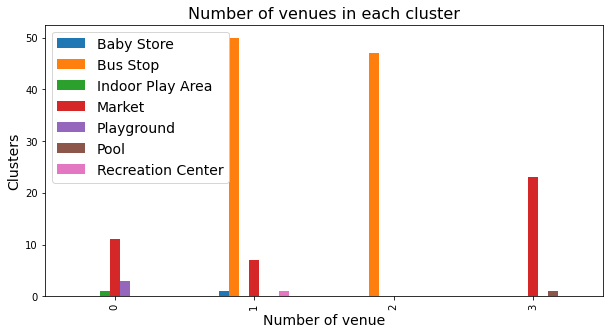

In [50]:
cv_cluster.plot(kind='bar',figsize=(10,5))
plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of venues in each cluster",fontsize= 16)
plt.xlabel('Number of venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

From the bar chart above, I will name 4 clusters as below:
* Cluster 0: Various markets & children friendly places  
* Cluster 1: Easy access by bus, various markets and baby stores
* Cluster 2: Easy access by bus
* Cluster 3: Various markets and pools

I create a dataframe and add the information of this dataframe into main dataframe

In [51]:
clusters ={'Cluster':[0,1,2,3], 'Friendly_cluster_labels': ['Various markets & children friendly places','Easy access by bus, various markets & baby stores','Easy access by bus','Various markets and pools']}
df_clusters = pd.DataFrame(clusters)
df_clusters

,Cluster,Friendly_cluster_labels
0,0,Various markets & children friendly places
1,1,"Easy access by bus, various markets & baby stores"
2,2,Easy access by bus
3,3,Various markets and pools


In [52]:
capital_region_merged = pd.merge(capital_region_merged, df_clusters, left_on = 'Cluster Labels', right_on = 'Cluster', how = 'left')

In [53]:
capital_region_merged.drop('Cluster',axis=1, inplace=True)
capital_region_merged.head()

,postalcode,Area,municipality,latitude,longitude,price_per_m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Friendly_cluster_labels
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316,7575,0,Playground,Market,Pool,Baby Store,Bus Stop,Various markets & children friendly places
1,00120,Punavuori,Helsinki,60.1632,24.9391,8160,0,Market,Playground,Pool,Baby Store,Bus Stop,Various markets & children friendly places
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487,7825,3,Pool,Market,Baby Store,Bus Stop,Indoor Play Area,Various markets and pools
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525,8713,0,Market,Playground,Baby Store,Bus Stop,Indoor Play Area,Various markets & children friendly places
4,00160,Katajanokka,Helsinki,60.1671,24.9684,7208,3,Market,Pool,Recreation Center,Tram Station,Baby Store,Various markets and pools


#### Adding labels for housing sale price in dataset

In [54]:
# Categorize and pick labels for housing sale prices (price_per_m2)
labels_price = capital_region_merged[['postalcode','price_per_m2']]
labels_price.head()

,postalcode,price_per_m2
0,00100,7575
1,00120,8160
2,00130,7825
3,00140,8713
4,00160,7208


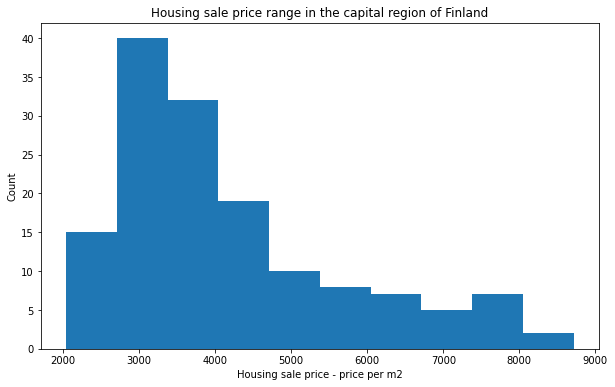

In [55]:
# plotting
labels_price['price_per_m2'].plot(kind='hist', figsize=(10,6))
plt.xlabel('Housing sale price - price per m2')
plt.ylabel('Count')
plt.title('Housing sale price range in the capital region of Finland')
plt.show()

I will define housing sale price into 5 labels: 'Low','Medium','High','Expensive','Very Expensive'. So, I would like to have 5 bins with equal size, I use linspace() function of numpy

In [56]:
bins = np.linspace(min(labels_price['price_per_m2']),max(labels_price['price_per_m2']),6)
bins

array([2044. , 3377.8, 4711.6, 6045.4, 7379.2, 8713. ])

In [57]:
# set group names
group_names = ['Low','Medium','High','Expensive','Very Expensive']
# add column: price_labels to dataframe
labels_price['price_lables'] = pd.cut(labels_price['price_per_m2'], bins, labels=group_names, include_lowest=True)
# the number of price_per_m2 in each bin
labels_price['price_lables'].value_counts()

<ipython-input-57-19e74e070020>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_price['price_lables'] = pd.cut(labels_price['price_per_m2'], bins, labels=group_names, include_lowest=True)


Low               55
Medium            51
High              18
Expensive         12
Very Expensive     9
Name: price_lables, dtype: int64

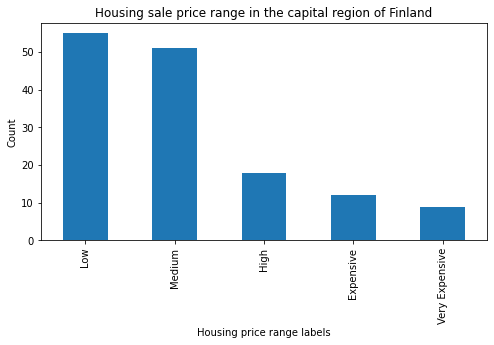

In [58]:
#plotting
labels_price['price_lables'].value_counts().plot(kind='bar', figsize=(8,4))
plt.xlabel('Housing price range labels')
plt.ylabel('Count')
plt.title('Housing sale price range in the capital region of Finland')
plt.show()

In [59]:
labels_price = labels_price.drop('price_per_m2',axis=1)

In [60]:
capital_region_merged = pd.merge(capital_region_merged,labels_price, on='postalcode')

In [61]:
capital_region_merged.head()

,postalcode,Area,municipality,latitude,longitude,price_per_m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Friendly_cluster_labels,price_lables
0,00100,Helsinki Keskusta - Etu-Töölö,Helsinki,60.1714,24.9316,7575,0,Playground,Market,Pool,Baby Store,Bus Stop,Various markets & children friendly places,Very Expensive
1,00120,Punavuori,Helsinki,60.1632,24.9391,8160,0,Market,Playground,Pool,Baby Store,Bus Stop,Various markets & children friendly places,Very Expensive
2,00130,Kaartinkaupunki,Helsinki,60.1645,24.9487,7825,3,Pool,Market,Baby Store,Bus Stop,Indoor Play Area,Various markets and pools,Very Expensive
3,00140,Kaivopuisto - Ullanlinna,Helsinki,60.1578,24.9525,8713,0,Market,Playground,Baby Store,Bus Stop,Indoor Play Area,Various markets & children friendly places,Very Expensive
4,00160,Katajanokka,Helsinki,60.1671,24.9684,7208,3,Market,Pool,Recreation Center,Tram Station,Baby Store,Various markets and pools,Expensive


In [62]:
#capital_region_merged.to_excel('fin_data_after_clustering.xlsx')

## 4. Result
The result is a map of each targed area with information of clustering and housing sale price

In [63]:
results = capital_region_merged

The result will be visulized on a Folium map 

In [64]:
# Let's get the geographical coordinates of Helsinki region 
address = 'Helsinki, Finland'

geolocator = Nominatim(user_agent="finland_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, price, price_label, cluster, cluster_label in zip(results['latitude'], results['longitude'], results['Area'], results['price_per_m2'], results['price_lables'],results['Cluster Labels'], results['Friendly_cluster_labels']):
    label = folium.Popup(str(poi) + ' - '+ str(price) + ' euros/m2 '+ ' - '+str(price_label) + ' - ' + str(cluster_label), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Discussion
This project aims to support the decision of particular house buyers with some requirements. The problem was raised by a family who would to know more about living location with some key factors such as children friendly places and public transportation nearby. They do not care about other services in an area like pub, cafe, restaurant or tourist attractions. Therefore, taking into account the requirements, I limited the categories of venue in dataset of every areas. The result of this analysis can be considered as an informative source to support the decision of a family in term of buying a house
As I mentioned before, the features of areas are limited based on requirements of buyer (children friendly areas but near public transportation), in the future development, the features can be extended more by using all data of returned venue categories.

Limitation
- I planed to visualize the housing sale price with choropleth map to give a stunning and clear visualization of housing sale price. However, I cannot find the detail geometry data of the capital region. I tried many sources (Spatial Data Repository of NYU, Paikkatietoikkuna, Paavo postal code area statistics, etc) but all I got was geometry of municipalities and cannot drill deeper. In the future, I will continue to find deeper geometry data of the capital region in order to make this analysis more informative to users.
- Limitation of FourSquare data. After examining the returned data from FourSquare, I found out that there is almost none of venue related to education available (only one DayCare returned). With a common knowledge of living in Finland, I know that in each area, there are several daycares, kindergartens and schools around. 

## 6. Conclusion
Purchasing a house or apartment is always a huge decision and investment in a family. Purpose of this project is to provide more informative data on certain location of living for house buyers as an trustful reference when they decide to invest their financial resource on an accommodation.